In [2]:
using GraphViz

using StockFlow
using StockFlow.Syntax
using StockFlow.Syntax.Stratification

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

using Catlab.Graphics.Graphviz: Html
using Catlab.Graphics.Graphviz


In [3]:
# Functions for graphing typed Petri nets
colors_vflow = ["antiquewhite4","antiquewhite", "gold", "saddlebrown", "slateblue", "blueviolet", "olive"]
colors_s = ["deeppink","darkorchid","darkred","coral"] # red series
colors_sv = ["cornflowerblue","cyan4","cyan","chartreuse"] # green and blue series
colors_p = ["gold","gold4","darkorange1","lightgoldenrod","goldenrod"] # yellow and orange

flatten(fname::Symbol) = "$fname"

function flatten(fname::Tuple)
    names = split(replace(string(fname), "("=>"", ")"=>"", ":"=>""), ",")
    for i in 1:length(names)
        name = strip(names[i])
        if name[1:2] == "id"
            continue
        end
        return name
    end
    return "id"
end

def_stock(typed_StockFlow::ACSetTransformation, colors) = 
  (p,s) -> ("s$s", Attributes(:label=>sname(p,s) isa Tuple where T ? Html(replace(string(sname(p,s)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(sname(p,s))",
                                     :shape=>"square", 
                                     :color=>"black", 
                                     :style=>"filled", 
                                     :fillcolor=>colors[typed_StockFlow[:S](s)]))

def_parameter(typed_StockFlow::ACSetTransformation, colors) = 
(p, pp) -> ("p$pp", Attributes(:label=>pname(p,pp) isa Tuple where T ? Html(replace(string(pname(p,pp)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(pname(p,pp))",
                                     :shape=>"circle", 
                                     :color=>colors[typed_StockFlow[:P](pp)],
                                     :fontcolor=>colors[typed_StockFlow[:P](pp)]))

def_auxiliaryVF(typed_StockFlow::ACSetTransformation, colors)=
  (p, v) -> ("v$v", Attributes(:label=>make_v_expr(p,v) isa Tuple where T ? Html(replace(string(make_v_expr(p,v)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(make_v_expr(p,v))",
                                          :shape=>"plaintext", 
                                          :fontcolor=>colors[typed_StockFlow[:V](v)]))


def_sumV(typed_StockFlow::ACSetTransformation, colors) = 
  (p, sv) -> ("sv$sv", Attributes(:label=>svname(p,sv) isa Tuple where T ? Html(replace(string(svname(p,sv)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(svname(p,sv))",
                                       :shape=>"circle", 
                                       :color=>"black",
                                       :fillcolor=>colors[typed_StockFlow[:SV](sv)], 
                                       :style=>"filled"))  


def_flow_V(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[typed_StockFlow[:F](f)]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
end
        
def_flow_noneV(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, f) -> begin
     colorType = colors[typed_StockFlow[:F](f)]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

def_flow_V(colors = colors_vflow)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[f]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
    
end
        
def_flow_noneV(colors = colors_vflow)=
  (p, us, ds, f) -> begin
     colorType = colors[f]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

GraphF_typed(typed_StockFlow::ACSetTransformation, colors_vflow = colors_vflow, colors_s = colors_s, colors_p = colors_p, colors_sv = colors_sv; schema::String="C", type::String="SFVL", rd::String="LR") = GraphF(dom(typed_StockFlow),
    make_stock = def_stock(typed_StockFlow, colors_s), make_auxiliaryV=def_auxiliaryVF(typed_StockFlow, colors_vflow), make_sumV=def_sumV(typed_StockFlow, colors_sv), 
    make_flow_V=def_flow_V(typed_StockFlow, colors_vflow), make_flow_noneV=def_flow_noneV(typed_StockFlow, colors_vflow),make_parameter=def_parameter(typed_StockFlow, colors_p),schema=schema, type=type, rd=rd
)

GraphF_typed (generic function with 5 methods)

In [4]:
diabetes_type = @stock_and_flow begin
    :stocks
    Pop

    :parameters
    rDeath
    rProgress
    rStrata

    :dynamic_variables
    v_death = rDeath * Pop
    v_progress = rProgress * Pop
    v_strata = rStrata * Pop

    :flows
    Pop => f_death(v_death) => CLOUD
    Pop => f_progress(v_progress) => Pop 
    Pop => f_strata(v_strata) => Pop

    :sums
    N = [Pop]

end

StockAndFlowF {S:1, SV:1, LS:1, F:3, I:2, O:3, V:3, LV:3, LSV:0, P:3, LVV:0, LPV:3, Name:0, Op:0, Position:0}
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │   Pop │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
└────┴─────┴──────┘
┌───┬────┬────────────┐
│ F │ fv │      fname │
├───┼────┼────────────┤
│ 1 │  1 │    f_death │
│ 2 │  2 │ f_progress │
│ 3 │  3 │   f_strata │
└───┴────┴────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   3 │  1 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   3 │  1 │
└───┴─────┴────┘
┌───┬────────────┬─────┐
│ V │      vname │ vop │
├───┼────────────┼─────┤
│ 1 │    v_death │   * │
│ 2 │ v_progress │   * │
│ 3 │   v_strata │   * │
└───┴────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   1 │           2 │
│  2 │   1 │   2 │           2 │
│  3 │   1 │   3 │           2 │
└────┴─────┴─────┴─────────────┘
┌───┬───────────┐
│ P │     pname │
├───┼───────────┤
│ 1 │    rDeath │
│ 2 │ rProgress │
│ 3 │   rStrata │
└───┴───────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    1 │            1 │
│   2 │    2 │    2 │            1 │
│   3 │    3 │    3 │            1 │
└─────┴──────┴──────┴──────────────┘

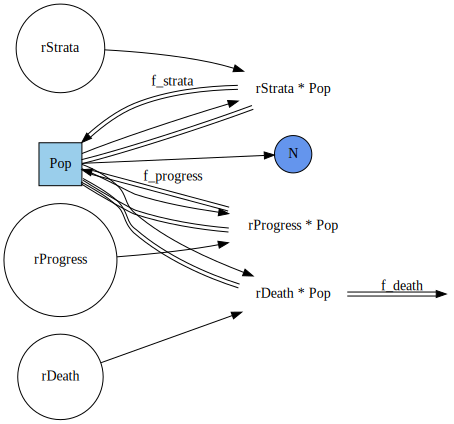

In [5]:
GraphF(diabetes_type)

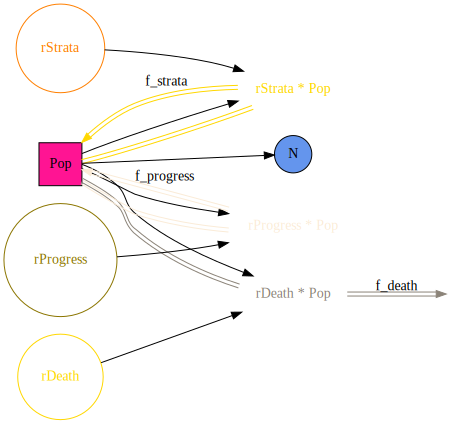

In [6]:
GraphF_typed(id(diabetes_type))

# Define the strata model

In [7]:
diagnosis_strata = @stock_and_flow begin

    :stocks
    U
    D

    :dynamic_variables
    v_death_U = rDeath_U * U
    v_progress_U = rProgress_U * U
    v_death_D = rDeath_D * D
    v_progress_D = rProgress_D * D
    v_strata = rDiagnosis * U

    :parameters
    rDeath_U
    rProgress_U
    
    rDeath_D
    rProgress_D
    
    rDiagnosis
    
    

    :flows
    U => f_death_U(v_death_U) => CLOUD
    U => f_progress_U(v_progress_U) => U
    
    D => f_death_D(v_death_D) => CLOUD
    D => f_progress_D(v_progress_D) => D

    U => f_strata(v_strata) => D


    :sums
    N = [U, D]


end

StockAndFlowF {S:2, SV:1, LS:2, F:5, I:3, O:5, V:5, LV:5, LSV:0, P:5, LVV:0, LPV:5, Name:0, Op:0, Position:0}
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     U │
│ 2 │     D │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
└────┴─────┴──────┘
┌───┬────┬──────────────┐
│ F │ fv │        fname │
├───┼────┼──────────────┤
│ 1 │  1 │    f_death_U │
│ 2 │  2 │ f_progress_U │
│ 3 │  3 │    f_death_D │
│ 4 │  4 │ f_progress_D │
│ 5 │  5 │     f_strata │
└───┴────┴──────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   4 │  2 │
│ 3 │   5 │  2 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   5 │  1 │
│ 4 │   3 │  2 │
│ 5 │   4 │  2 │
└───┴─────┴────┘
┌───┬──────────────┬─────┐
│ V │        vname │ vop │
├───┼──────────────┼─────┤
│ 1 │    v_death_U │   * │
│ 2 │ v_progress_U │   * │
│ 3 │    v_death_D │   * │
│ 4 │ v_progress_D │   * │
│ 5 │     v_strata │   * │
└───┴──────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   1 │           2 │
│  2 │   1 │   2 │           2 │
│  3 │   2 │   3 │           2 │
│  4 │   2 │   4 │           2 │
│  5 │   1 │   5 │           2 │
└────┴─────┴─────┴─────────────┘
┌───┬─────────────┐
│ P │       pname │
├───┼─────────────┤
│ 1 │    rDeath_U │
│ 2 │ rProgress_U │
│ 3 │    rDeath_D │
│ 4 │ rProgress_D │
│ 5 │  rDiagnosis │
└───┴─────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    1 │            1 │
│   2 │    2 │    2 │            1 │
│   3 │    3 │    3 │            1 │
│   4 │    4 │    4 │            1 │
│   5 │    5 │    5 │            1 │
└─────┴──────┴──────┴──────────────┘

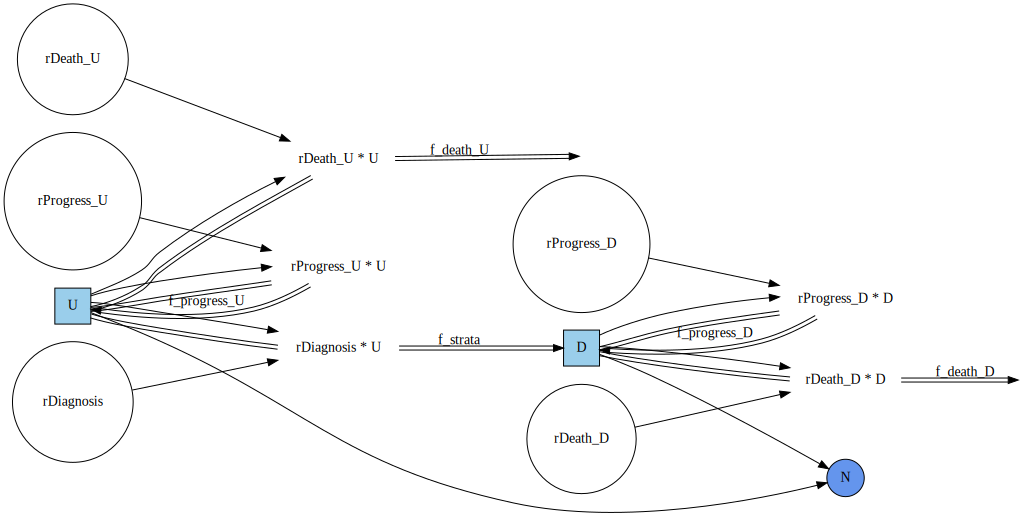

In [8]:
GraphF(diagnosis_strata)

# Define the progress model

In [9]:
diabetes_progress = @stock_and_flow begin
    :stocks
    PreDiabetic
    DiabeticWtComp
    DiabeticEarly
    DiabeticLate

    :parameters
    
    rDevelopingDiabetic
    rDevelopingEarly
    rDevelopingLate
    
    rMortalityPreDiabetic
    rMortalityDiabeticEarly
    rMortalityDiabeticLate
    rMortalityDiabeticWtComp
    

    rDiagnosePreDiabetic
    rDiagnoseDiabeticWtComp
    rDiagnoseDiabeticEarly
    rDiagnoseDiabeticLate

    :dynamic_variables
    v_DevelopingDiabetic = PreDiabetic * rDevelopingDiabetic
    v_DevelopingEarly = DiabeticWtComp * rDevelopingEarly
    v_DevelopingLate = DiabeticEarly * rDevelopingLate

    v_DeathPreDiabetic = PreDiabetic * rMortalityPreDiabetic
    v_DeathDiabeticWtComp = DiabeticWtComp * rMortalityDiabeticWtComp
    v_DeathDiabeticEarly = DiabeticEarly * rMortalityDiabeticEarly
    v_DeathDiabeticLate = DiabeticLate * rMortalityDiabeticLate

    v_DiagnosePreDiabetic = PreDiabetic * rDiagnosePreDiabetic
    v_DiagnoseDiabeticWtComp = DiabeticWtComp * rDiagnoseDiabeticWtComp
    v_DiagnoseDiabeticEarly = DiabeticEarly * rDiagnoseDiabeticEarly
    v_DiagnoseDiabeticLate = DiabeticLate * rDiagnoseDiabeticLate

    :flows
    PreDiabetic => f_DevelopingDiabetic(v_DevelopingDiabetic) => DiabeticWtComp
    PreDiabetic => f_DeathPreDiabetic(v_DeathPreDiabetic) => CLOUD
    DiabeticWtComp => f_DevelopingEarly(v_DevelopingEarly) => DiabeticEarly
    DiabeticWtComp => f_DeathDiabeticWtComp(v_DeathDiabeticWtComp) => CLOUD
    DiabeticEarly => f_DevelopingLate(v_DevelopingLate) => DiabeticLate
    DiabeticEarly => f_DeathDiabeticEarly(v_DeathDiabeticEarly) => CLOUD
    DiabeticLate => f_DeathDiabeticLate(v_DeathDiabeticLate) => CLOUD

    PreDiabetic => f_DiagnosePreDiabetic(v_DiagnosePreDiabetic) => PreDiabetic
    DiabeticWtComp => f_DiagnoseDiabeticWtComp(v_DiagnoseDiabeticWtComp) => DiabeticWtComp
    DiabeticEarly => f_DiagnoseDiabeticEarly(v_DiagnoseDiabeticEarly) => DiabeticEarly
    DiabeticLate => f_DiagnoseDiabeticLate(v_DiagnoseDiabeticLate) => DiabeticLate

    :sums
    N = [PreDiabetic, DiabeticWtComp, DiabeticEarly, DiabeticLate]

end

StockAndFlowF {S:4, SV:1, LS:4, F:11, I:7, O:11, V:11, LV:11, LSV:0, P:11, LVV:0, LPV:11, Name:0, Op:0, Position:0}
┌───┬────────────────┐
│ S │          sname │
├───┼────────────────┤
│ 1 │    PreDiabetic │
│ 2 │ DiabeticWtComp │
│ 3 │  DiabeticEarly │
│ 4 │   DiabeticLate │
└───┴────────────────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
│  4 │   4 │    1 │
└────┴─────┴──────┘
┌────┬────┬──────────────────────────┐
│  F │ fv │                    fname │
├────┼────┼──────────────────────────┤
│  1 │  1 │     f_DevelopingDiabetic │
│  2 │  4 │       f_DeathPreDiabetic │
│  3 │  2 │        f_DevelopingEarly │
│  4 │  5 │    f_DeathDiabeticWtComp │
│  5 │  3 │         f_DevelopingLate │
│  6 │  6 │     f_DeathDiabeticEarly │
│  7 │  7 │      f_DeathDiabeticLate │
│  8 │  8 │    f_DiagnosePreDiabetic │
│  9 │  9 │ f_DiagnoseDiabeticWtComp │
│ 10 │ 10 │  f_DiagnoseDiabeticEarly │
│ 11 │ 11 │   f_DiagnoseDiabeticLate │
└────┴────┴──────────────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   8 │  1 │
│ 2 │   1 │  2 │
│ 3 │   9 │  2 │
│ 4 │   3 │  3 │
│ 5 │  10 │  3 │
│ 6 │   5 │  4 │
│ 7 │  11 │  4 │
└───┴─────┴────┘
┌────┬─────┬────┐
│  O │ ofn │ os │
├────┼─────┼────┤
│  1 │   1 │  1 │
│  2 │   2 │  1 │
│  3 │   8 │  1 │
│  4 │   3 │  2 │
│  5 │   4 │  2 │
│  6 │   9 │  2 │
│  7 │   5 │  3 │
│  8 │   6 │  3 │
│  9 │  10 │  3 │
│ 10 │   7 │  4 │
│ 11 │  11 │  4 │
└────┴─────┴────┘
┌────┬──────────────────────────┬─────┐
│  V │                    vname │ vop │
├────┼──────────────────────────┼─────┤
│  1 │     v_DevelopingDiabetic │   * │
│  2 │        v_DevelopingEarly │   * │
│  3 │         v_DevelopingLate │   * │
│  4 │       v_DeathPreDiabetic │   * │
│  5 │    v_DeathDiabeticWtComp │   * │
│  6 │     v_DeathDiabeticEarly │   * │
│  7 │      v_DeathDiabeticLate │   * │
│  8 │    v_DiagnosePreDiabetic │   * │
│  9 │ v_DiagnoseDiabeticWtComp │   * │
│ 10 │  v_DiagnoseDiabeticEarly │   * │
│ 11 │   v_DiagnoseDiabeticLate │   * │
└────┴──────────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   1 │           1 │
│  2 │   2 │   2 │           1 │
│  3 │   3 │   3 │           1 │
│  4 │   1 │   4 │           1 │
│  5 │   2 │   5 │           1 │
│  6 │   3 │   6 │           1 │
│  7 │   4 │   7 │           1 │
│  8 │   1 │   8 │           1 │
│  9 │   2 │   9 │           1 │
│ 10 │   3 │  10 │           1 │
│ 11 │   4 │  11 │           1 │
└────┴─────┴─────┴─────────────┘
┌────┬──────────────────────────┐
│  P │                    pname │
├────┼──────────────────────────┤
│  1 │      rDevelopingDiabetic │
│  2 │         rDevelopingEarly │
│  3 │          rDevelopingLate │
│  4 │    rMortalityPreDiabetic │
│  5 │  rMortalityDiabeticEarly │
│  6 │   rMortalityDiabeticLate │
│  7 │ rMortalityDiabeticWtComp │
│  8 │     rDiagnosePreDiabetic │
│  9 │  rDiagnoseDiabeticWtComp │
│ 10 │   rDiagnoseDiabeticEarly │
│ 11 │    rDiagnoseDiabeticLate │
└────┴──────────────────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    1 │            2 │
│   2 │    2 │    2 │            2 │
│   3 │    3 │    3 │            2 │
│   4 │    4 │    4 │            2 │
│   5 │    7 │    5 │            2 │
│   6 │    5 │    6 │            2 │
│   7 │    6 │    7 │            2 │
│   8 │    8 │    8 │            2 │
│   9 │    9 │    9 │            2 │
│  10 │   10 │   10 │            2 │
│  11 │   11 │   11 │            2 │
└─────┴──────┴──────┴──────────────┘

In [15]:
strat_model = sfstratify(diagnosis_strata, diabetes_type, diabetes_progress, quote
    
    :parameters
    ~Death => rDeath <= ~Mortality
    rDiagnosis => rStrata <= ~Diagnose
    ~Progress => rProgress <= ~Developing

    :dynamic_variables
    ~death => v_death <= ~Death
    ~strata => v_strata <= ~Diagnose
    ~progress => v_progress <= ~Developing

    :flows
    ~death => f_death <= ~Death
    ~strata => f_strata <= ~Diagnose
    ~progress => f_progress <= ~Developing


end)

S,sname
1,UPreDiabetic
2,DPreDiabetic
3,UDiabeticWtComp
4,DDiabeticWtComp
5,UDiabeticEarly
6,DDiabeticEarly
7,UDiabeticLate
8,DDiabeticLate
SV,svname
1,NN


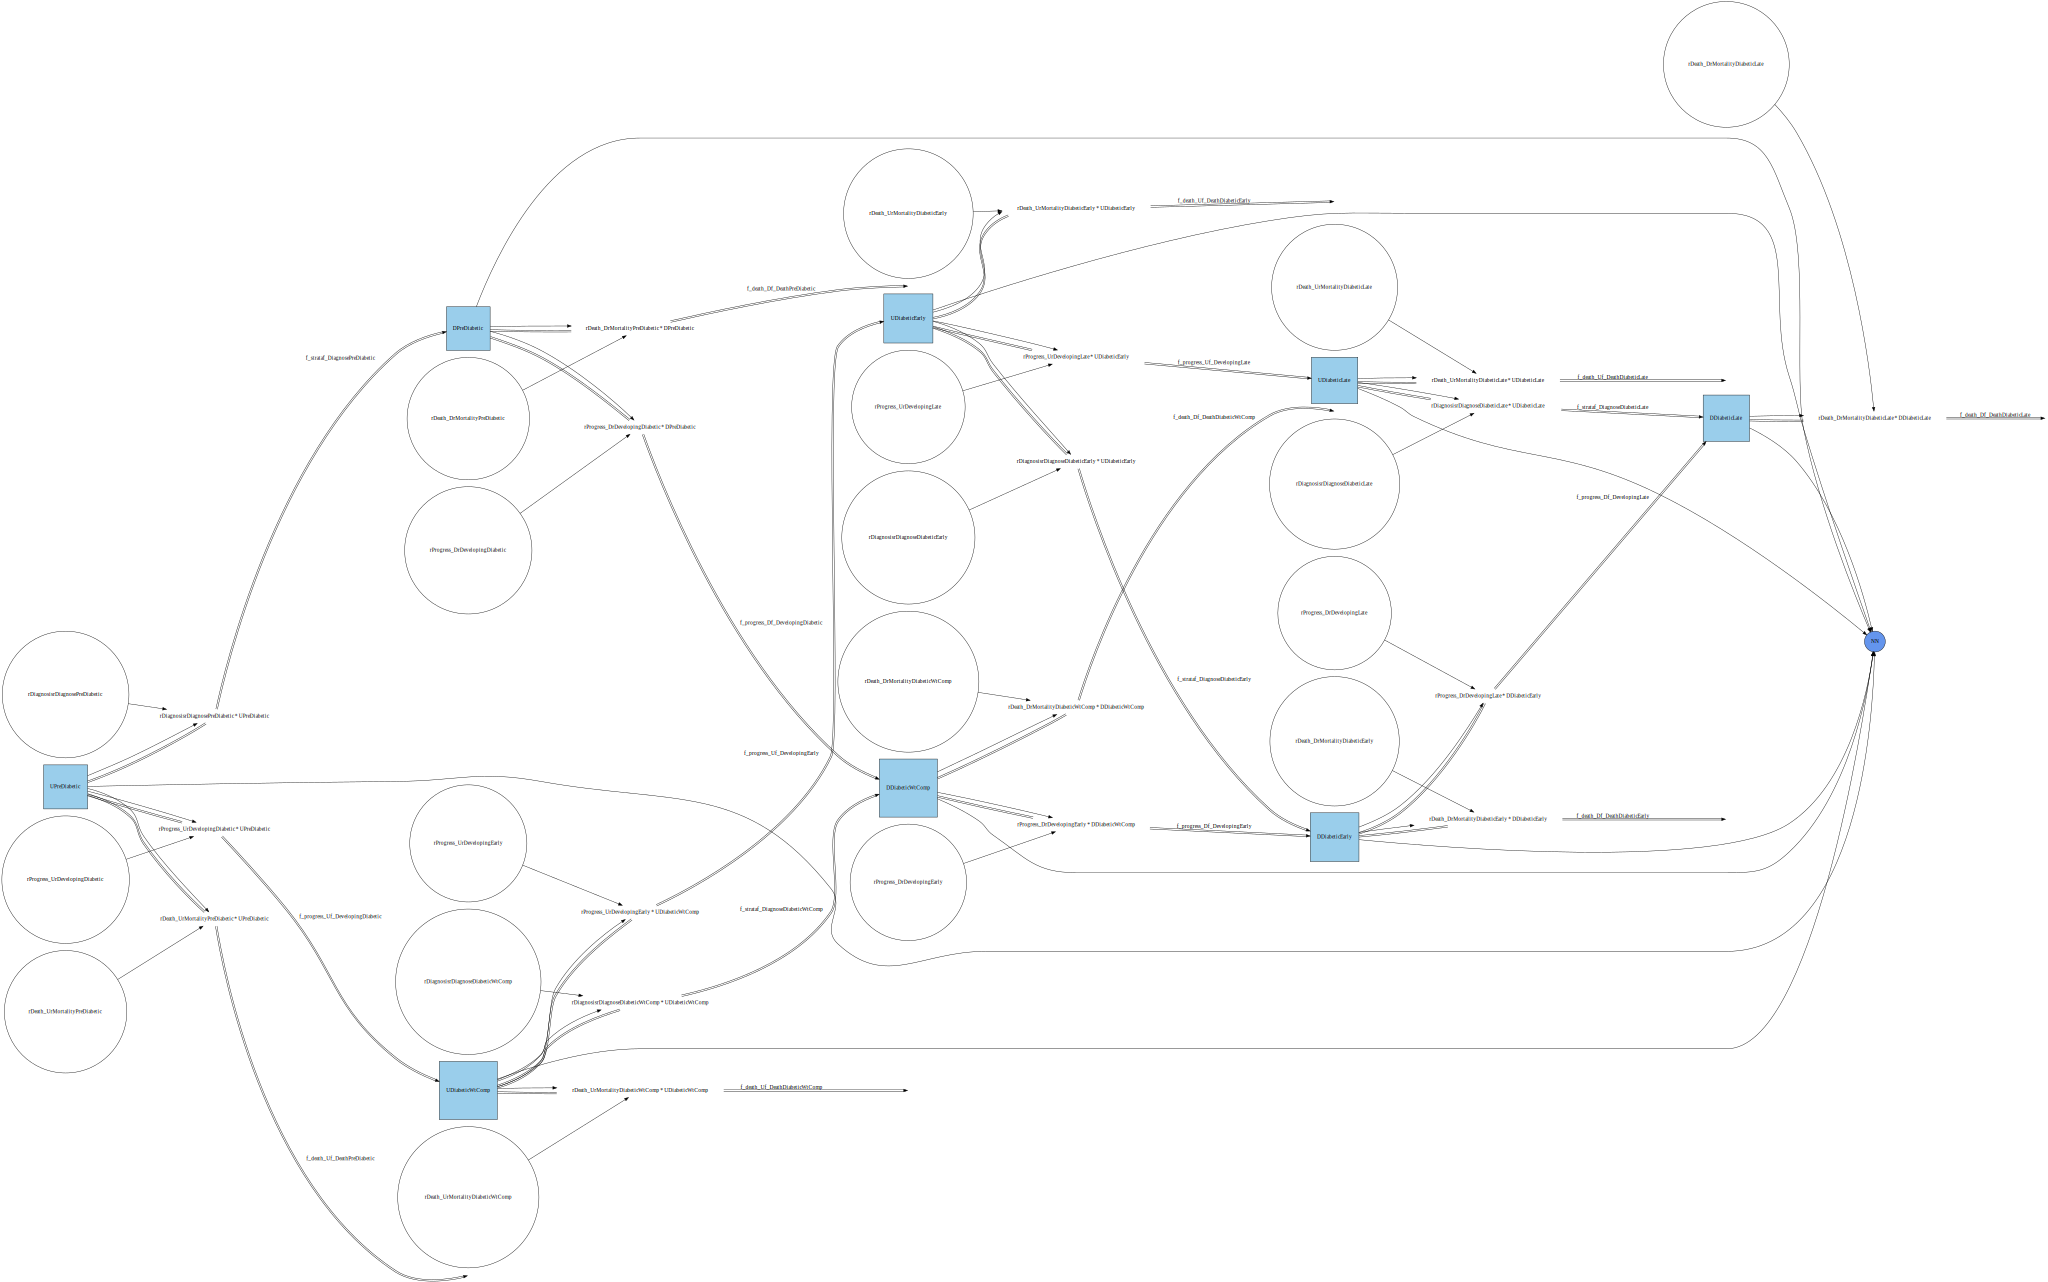

In [19]:
GraphF(strat_model)

In [17]:
# to have the figures plotted fix to the wider of the cells
HTML("""
<style>
.output_svg div{
  width: 100% !important;
  height: 100% !important;
}
</style>
""")


HTML{String}("<style>\n.output_svg div{\n  width: 100% !important;\n  height: 100% !important;\n}\n</style>\n")